<center>
<img src="logo.png" height="900"> 
</center>


#  Описательные статистики и сегментация

На основе описательных статистик можно выстраивать различные простейшие алгоритмы. Например, мы можем рассчитать среднее за какой-то период и использовать его для прогноза (наивный прогноз). В этой тетрадке мы попробуем заняться сегментацией на основе квантилей.

In [1]:
import numpy as np         # библиотека для матриц и математики
import pandas as pd        # библиотека для работы с табличками
from scipy import stats    # модуль для работы со статистикой

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')    # стиль графиков
%matplotlib inline

Будем работать с данными по покупкам. 

In [3]:
df = pd.read_excel("data/Online Retail.xlsx")
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


__Проверим есть ли в данных пропуски.__ 

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Да, в данных есть пропуски. Их надо почистить от них. Либо заполнить либо удалить. Сегментировать покупки, id клиента для которых неизвестен, не получится. Выбросим из рассмотрения эти колонки. 

In [7]:
df = df[df['CustomerID'].notnull()]
df.shape

(406829, 8)

Снова посмотрим на пропуски. 

In [8]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [9]:
df.fillna(0)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


Пропусков не осталось. Посмотрим на топ-10 стран по уникальным пользователям.

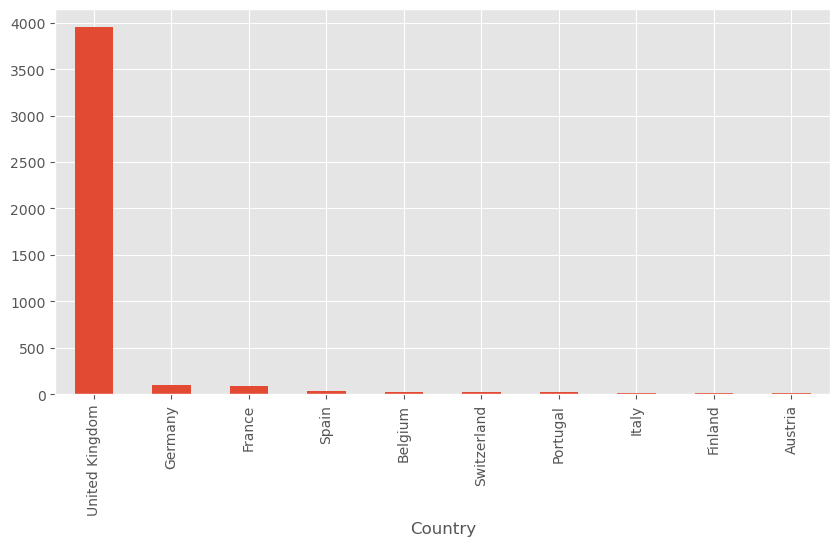

In [10]:
g = (
    df.groupby('Country')['CustomerID']
    .agg('nunique')
    .sort_values(ascending=False)[:10]
    .plot(kind='bar', figsize=(10,5))
)

g;

Будем работать только с Великобританией. 

In [11]:
uk_data = df[df.Country=='United Kingdom']
uk_data.shape

(361878, 8)

In [12]:
uk_data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,361878.000000,361878,361878.000000,361878.000000
mean,11.077029,2011-07-10 23:48:12.301493760,3.256007,15547.871368
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 17:25:00,1.250000,14194.000000
50%,4.000000,2011-07-31 13:07:00,1.950000,15514.000000
75%,12.000000,2011-10-23 11:39:00,3.750000,16931.000000
max,80995.000000,2011-12-09 12:49:00,38970.000000,18287.000000
std,263.129266,NaN,70.654731,1594.402590


Видно, что судя по данным некоторые клиенты сделали отрицательные заказы. __Это явная ошибка в данных.__ Отфильтруем только те заказы, где сумма покупки оказалась положительной. 

In [13]:
uk_data = uk_data[uk_data['Quantity'] > 0]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  object        
 1   StockCode    354345 non-null  object        
 2   Description  354345 non-null  object        
 3   Quantity     354345 non-null  int64         
 4   InvoiceDate  354345 non-null  datetime64[ns]
 5   UnitPrice    354345 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      354345 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


Будем сегментировать клиентов по RFM. 

- __Recency (Свежесть) -__ число дней насколько давно пользователь что-то у нас покупал 
- __Frequency (Частота) -__ насколько много заказов пользовать сделал
- __Monetary (Деньги) -__ сколько в сумме денег потратил

Клиенты, которые пришли недавно, много и часто покупали - лучшие клиенты. 

In [14]:
uk_data = uk_data[['CustomerID', 'InvoiceDate', 
                   'InvoiceNo', 'Quantity', 'UnitPrice']]
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39
2,17850.0,2010-12-01 08:26:00,536365,8,2.75
3,17850.0,2010-12-01 08:26:00,536365,6,3.39
4,17850.0,2010-12-01 08:26:00,536365,6,3.39


In [15]:
# колонка с итоговой суммой, потраченной при покупке
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']

In [16]:
# диапазон, когда поступали заказы
uk_data['InvoiceDate'].min(), uk_data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [17]:
import datetime as dt
PRESENT = dt.datetime(2011,12,10) # самая новая дата

uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])

In [18]:
rfm = (
    uk_data.groupby('CustomerID')
    .agg({
        'InvoiceDate': lambda date: (PRESENT - date.max()).days, # дней с последней покупки 
        'InvoiceNo': 'count',                                    # число заказов
        'TotalPrice': 'sum'                                      # суммарные траты
    })
)

In [19]:
rfm.columns

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [20]:
rfm.columns = ['recency', 'frequency', 'monetary']

In [21]:
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


Посмотрим на то как распределены наши характеристики, которые мы построили для сегментации. 

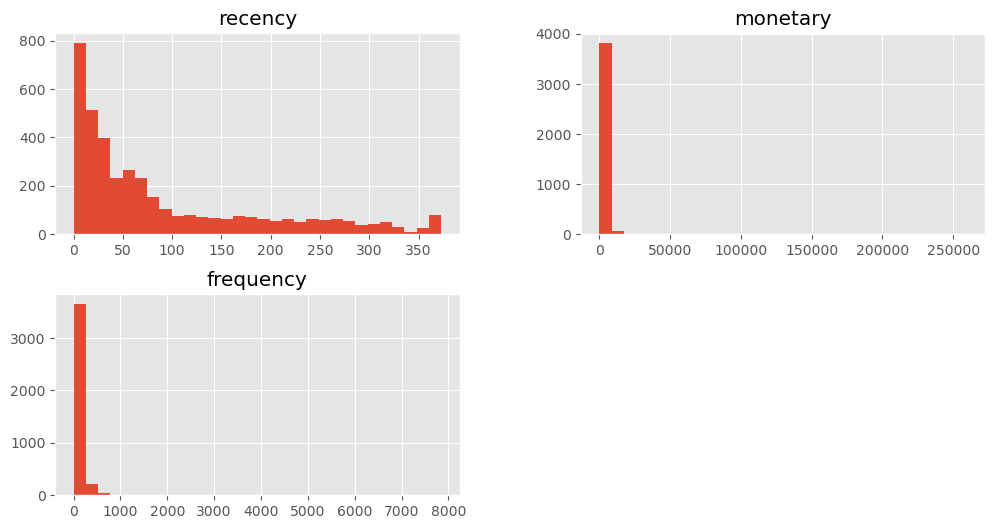

In [22]:
rfm[['recency', 'monetary', 'frequency']].hist(figsize=(12,6), bins=30);

Видим довольно длинные хвосты. Чтобы визуализация оказалась более информативной, давайте прологарифмируем наши переменные. 

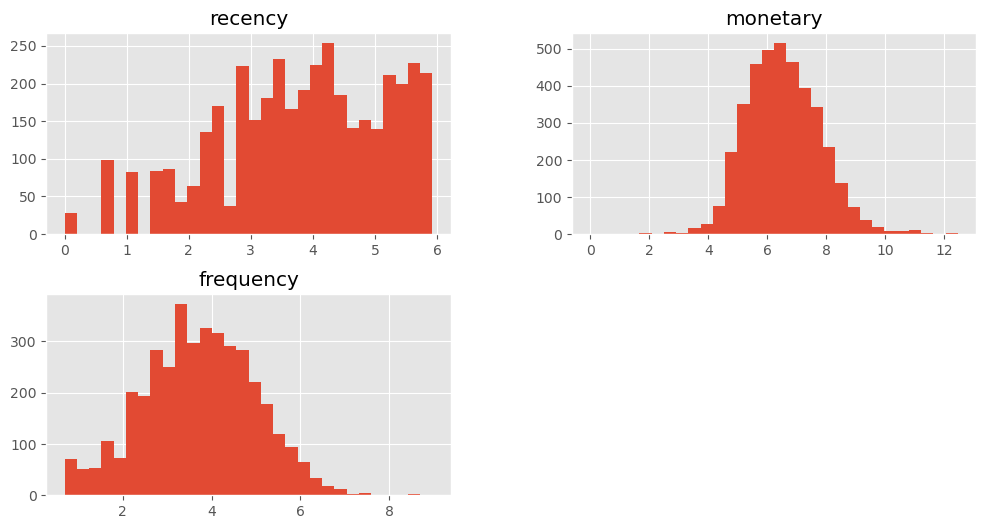

In [23]:
g = (
    rfm[['recency', 'monetary', 'frequency']]
    .apply(lambda w: np.log(w + 1))
    .hist(figsize=(12,6), bins=30)
)

g;

In [24]:
rfm[['recency', 'frequency', 'monetary']] = rfm[['recency', 'frequency', 'monetary']].apply(lambda w: np.log(w + 1))

Мы будем использовать для сегментации квартили, поэтому для нас выбросы не проблема. Данные от них очищать не будем. Номер соотвествующего квартиля помогает найти команда `qcut()`.

In [25]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [26]:
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,5.786897,0.693147,11.253955,4,4,1
12747.0,1.098612,4.644391,8.342128,1,1,1
12748.0,0.000000,8.433159,10.425868,1,1,1
12749.0,1.386294,5.298317,8.316760,1,1,1
12820.0,1.386294,4.094345,6.849427,1,2,2


Создадим единую колонку с номерами сегментов.

In [27]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str) + rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)

In [28]:
rfm

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,5.786897,0.693147,11.253955,4,4,1,441
12747.0,1.098612,4.644391,8.342128,1,1,1,111
12748.0,0.000000,8.433159,10.425868,1,1,1,111
12749.0,1.386294,5.298317,8.316760,1,1,1,111
12820.0,1.386294,4.094345,6.849427,1,2,2,122
...,...,...,...,...,...,...,...
18280.0,5.627621,2.397895,5.201806,4,4,4,444
18281.0,5.198497,2.079442,4.404522,4,4,4,444
18282.0,2.079442,2.564949,5.187665,1,4,4,144


Посмотрим в какой сегмент сколько пользователей попало. Нас больше всего интересует сегмент $111$. Меньше всего $444$.

<Axes: xlabel='RFM_Score', ylabel='count'>

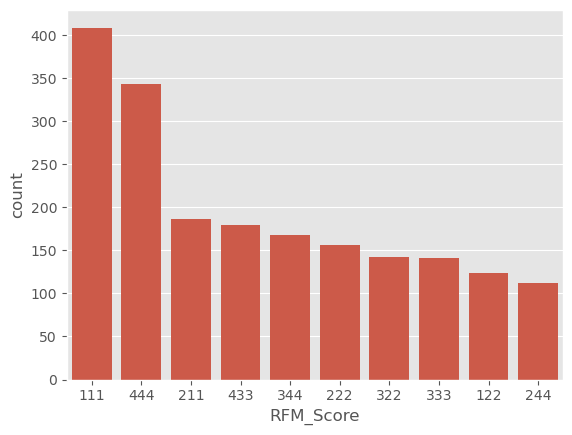

In [46]:
tmp = pd.DataFrame(rfm['RFM_Score'].value_counts()[:10]).reset_index()
sns.barplot(tmp, x='RFM_Score', y='count')

Выберем из таблички наших самых преданных покупателей. 

In [30]:
rfm[rfm['RFM_Score'] == '111'].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
18102.0,0.000000,6.068426,12.467122,1,1,1,111
17450.0,2.197225,5.823046,12.178454,1,1,1,111
17511.0,1.098612,6.871091,11.419311,1,1,1,111
16684.0,1.609438,5.627621,11.107279,1,1,1,111
14096.0,1.609438,8.539346,11.084690,1,1,1,111


Для визуализации оставим только те кластеры, куда попало больше $100$ человек. 

In [31]:
clusters = rfm['RFM_Score'].value_counts()
big_clusters = clusters[clusters > 100].index.values
big_clusters

array(['111', '444', '211', '433', '344', '222', '322', '333', '122',
       '244', '233', '443'], dtype=object)

Нарисуем интерактивную визуализацию. 

In [35]:
# !pip install plotly
%matplotlib inline

In [36]:
import plotly.express as px

px.scatter_3d(
    rfm[rfm.RFM_Score.isin(big_clusters)],
    x='recency',
    y='frequency',
    z='monetary',
    color='RFM_Score'
)

В этой тетрадке мы:

- Сделали сегментацию клиентов на основе описательных статистик 
- Посмотрели какие в данных могут возникать проблемы (выбросы, пропуски, ошибки) и постарались решить их. 